In [1]:
#Nozzle Thrust and Altitude Simulation
# Peter Strohmaier 9/1/19
# HALE Rocket Team


import numpy as np
import matplotlib.pyplot as plt
import math
% matplotlib notebook

#Conversions
def poundpersec_to_kilogrampersec(i):
    return i * 0.453592
def pound_to_kilogram(i):
    return i * 0.453592
def poundforce_to_newton(i):
    return i * 4.44822
def inch_to_meter(i):
    return i * 0.0254
def metersquare_to_inchsquare(i):
    return i * 1550
def poundpersec_to_kilogrampersec(i):
    return i * 0.453592
def psi_to_Pa(i):
    return i * 6894.76

#Defining Arrays and Start Points
t = 0
Accrocket = 0 #Acceleration of Rocket
Vrocket = 0 #Velocity of Rocket, m/s
Altitude = 0 #Altitude, m
Max_Altitude = 0
dt = 0.01
Max_Altitude_All = np.array([])
Acc_mat = np.array([])
Velocity_mat = np.array([])
Altitude_mat = np.array([])
TimeCount = np.array([])

#Placeholder to check max net force
Fnet_mat = np.array([])

#Known Values
expansion_ratio = np.linspace(1.0, 40.0, num = 40)
mdot = poundpersec_to_kilogrampersec(7.72) #kg/s
m_full = pound_to_kilogram(150) #kg
Cd = 2
Arocket = math.pi*((inch_to_meter(6)/2)**2) #External Cross-Sectional Area, m^2
g0 = 9.81 #m/s^2
gc = 1
Mai = 0
Mat = 1
Pcimp = 350  #psi
Pc = psi_to_Pa(Pcimp)
Pe = 101325 #Pa
k = 1.228
Ta = 3600  #K
Rbar = 8314 #J/K-mol
R = 389.4145 #J/kgK

In [2]:
#Isentropic Nozzle Calculations 
#taken from: Isentropic_Calculations_Version1_PeterStrohmaier.ipynb

#Stagnation Point Computations
Pt = Pc*((1+((k-1)/2)*(Mai**2))**(k/(k-1)))    #Equation 4.21 Fundamentals of Gas Dynamics (FGD)
Tt = Ta*(1+((k-1)/2)*(Mai**2))                 #Equation 4.18 FGD
PresRat = Pe/Pt

#Computing Area of Throat
rt1 = math.sqrt((2/(k+1))**((k+1)/(k-1)))      #Equation 3-24 Rocket Propulsion Elements (RPE)
rt2 = math.sqrt(k*R*Ta)
At = mdot/(Pc*k*(rt1/rt2))
Atimp = metersquare_to_inchsquare(At)
Dt = 2*math.sqrt(Atimp/math.pi)

#Exit Condition Calculations
Mae = (math.sqrt(2)*math.sqrt(Pt*((Pe/Pt)**(1/k))-Pe))/(math.sqrt((k*Pe)-Pe))    #Equation 5.4 FGD
Ae = (At/Mae)*(((1+((k-1)/2)*(Mae**2))/((k+1)/2))**((k+1)/(2*(k-1))))            #Equation 5.37 FGD
exp_sealevel = Ae/At
Te = Tt/(1+((k-1)/2)*(Mae**2))
TempRat = Te/Tt
Aeimp = metersquare_to_inchsquare(Ae)
De = 2*math.sqrt(Aeimp/math.pi)

#Sonic Velocity
a = math.sqrt(k*gc*R*Ta) 

In [3]:
#Density as a Function of Altitude
def air_density(i):
    altitude = np.array([0,1000,3000,5000,10000,25000,50000,75000,100000,\
                     130000,160000,200000,300000,400000,600000,1000000])
    density = np.array([1.2250,1.1117,9.0912*(10**-1),7.6312*(10**-1),4.1351*(10**-1),\
                   4.0084*(10**-2),1.0269*(10**-3),3.4861*(10**-5),5.604*(10**-7),\
                   8.152*(10**-9),1.233*(10**-9),2.541*(10**-10),1.916*(10**-11),\
                   2.803*(10**-12),2.137*(10**-13),3.561*(10**-15)])
    return np.interp(i,altitude,density) #kg/m^3

#Ambient Pressure as a Function of Altitude
def air_pressure(i):
    altitude = np.array([0,1000,3000,5000,10000,25000,50000,75000,100000,\
                     130000,160000,200000,300000,400000,600000,1000000])
    pressure_ratio = np.array([1,8.8700*(10**-1),6.6919*(10**-1),5.3313*(10**-1),\
                              2.6151*(10**-1),2.5158*(10**-2),7.8735*(10**-4),2.0408*(10**-5),\
                              3.1593*(10**-7),1.2341*(10**-8),2.9997*(10**-9),8.3628*(10**-10),\
                              8.6557*(10**-11),1.4328*(10**-11),8.1056*(10**-13),7.4155*(10**-14)])
    x = np.interp(i,altitude,pressure_ratio)
    return x * Pe #Pa



In [4]:
#Function for Thrust Force
def Fthrust(exp,Altitude):
    A_exit = exp * At
    #Guess for Mach number
    Mach_exit = 2
    for i in range(100):
        Mach_exit = (1/exp)*(((1+((k-1)/2)*(Mach_exit**2))/((k+1)/2))**((k+1)/(2*(k-1))))

    P_exit = Pt/((1+(((k-1)/2)*(Mach_exit**2)))**(k/(k-1)))
    V_exit = Mach_exit * a
    Fthrust = ((mdot*V_exit)/gc) + A_exit*(P_exit-air_pressure(Altitude))
    return Fthrust
 

In [5]:
#Function for Drag Force
def Fdrag(Vrocket,Altitude):
    return (Cd*(Vrocket**2)*air_density(Altitude)*Arocket)/2 #N
    

In [6]:
#Flight Performance Simulation

#Primary Iteration Over Each Expansion Ratio
#for exp in np.nditer(expansion_ratio):
  #  #Seconday Iteration for each time step
 #   for i in range(2000):
   #     t = t + dt
    #    #Updating the Instantaneous Mass
     #   if t < 5.21:
      #      m_PropellantConsumed = mdot*t
       #     m_inst = m_full - m_PropellantConsumed
        #    Weight = m_inst*g0
         #   Fnet = Fthrust(exp,Altitude) - Fdrag(Vrocket,Altitude) - Weight
      #  else:
       #     Weight = m_inst*g0
        #    if Vrocket < 0:
         #       Fnet =  Fdrag(Vrocket,Altitude) - Weight
          #  else:
           #     Fnet =  -Fdrag(Vrocket,Altitude) - Weight
        
       # Accrocket = Fnet/m_inst
       # Vrocket = Vrocket + Accrocket*dt
       # Altitude = Altitude + Vrocket*dt
        
       # if Altitude > Max_Altitude:
        #    Max_Altitude = Altitude
       # else: 
        #    break 
    
   # Max_Altitude_All = np.append(Max_Altitude_All,Max_Altitude)   
   # t = 0     

Maximum Net Force: 120885.21185718698
Maximum Altitude Reached: 111087.50176575866


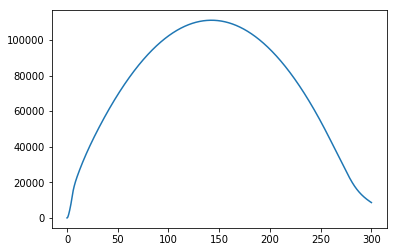

In [7]:
#Final Flight Simulation

exp = 20
for i in range(30000):
        t = t + dt
        #Updating the Instantaneous Mass
        if t < 5.21:
            m_PropellantConsumed = t*mdot
            m_inst = m_full - m_PropellantConsumed
            Weight = m_inst*g0
            Fnet = Fthrust(exp,Altitude) - Fdrag(Vrocket,Altitude) - Weight
            Fnet_mat = np.append(Fnet_mat,Fnet)
        else:
            Weight = m_inst*g0
            if Vrocket < 0:
                Fnet =  Fdrag(Vrocket,Altitude) - Weight
                Fnet_mat = np.append(Fnet_mat,Fnet)
            else:
                Fnet = -Fdrag(Vrocket,Altitude) - Weight
                Fnet_mat = np.append(Fnet_mat,Fnet)
        
        Accrocket = Fnet/m_inst
        Vrocket = Vrocket + Accrocket*dt
        Altitude = Altitude + Vrocket*dt
        
        Acc_mat = np.append(Acc_mat,Accrocket)
        Velocity_mat = np.append(Velocity_mat,Vrocket)
        Altitude_mat = np.append(Altitude_mat,Altitude)
        TimeCount = np.append(TimeCount,t)
        
F = max(Fnet_mat)
print('Maximum Net Force: ' + str(F))
print('Maximum Altitude Reached: ' + str(max(Altitude_mat)))
plt.plot(TimeCount,Altitude_mat)




#################################################
#Currently, I believe there is an error in the force function causing the net force to be
#much higher than it should be. This is likely causing the altitude to be much higher than
#it should be as well.


In [8]:
#Plotting Expansion Ratio vs Altitude

#plt.plot(expansion_ratio,Max_Altitude_All)

